# Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import pickle
import cv2
import timm
import umap
import hdbscan
import matplotlib.pyplot as plt

from PIL import Image, ImageFile
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Data Loading

In [3]:
train_data = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
test_data = pd.read_csv('/kaggle/input/UBC-OCEAN/test.csv')

# Balancing Class Distributions

In [4]:
# First, we separate TMA and non-TMA images
tma_data = train_data[train_data['is_tma'] == True]
non_tma_data = train_data[train_data['is_tma'] == False]

# Since we want to keep all TMA images, let's focus on balancing the non-TMA images
# We will undersample non-TMA images to the size of the smallest class within non-TMAs
smallest_class_count = non_tma_data['label'].value_counts().min()
undersampled_non_tma_data = pd.DataFrame()

# Perform undersampling for each label within non-TMA data
for label in non_tma_data['label'].unique():
    label_data = non_tma_data[non_tma_data['label'] == label]
    undersampled_label_data = resample(label_data,
                                       replace=False, # sample without replacement
                                       n_samples=smallest_class_count, # to match smallest class count
                                       random_state=123) # reproducible results
    undersampled_non_tma_data = pd.concat([undersampled_non_tma_data, undersampled_label_data])

# Now combine the undersampled non-TMA data with the original TMA data
combined_data = pd.concat([undersampled_non_tma_data, tma_data])

# Shuffle the combined dataset
balanced_combined_data = combined_data.sample(frac=1, random_state=123).reset_index(drop=True)

# Let's check the new distribution
new_label_distribution = balanced_combined_data['label'].value_counts()
new_tma_distribution = balanced_combined_data['is_tma'].value_counts(normalize=True)

new_label_distribution, new_tma_distribution

(label
 MC      46
 CC      46
 HGSC    46
 LGSC    46
 EC      46
 Name: count, dtype: int64,
 is_tma
 False    0.891304
 True     0.108696
 Name: proportion, dtype: float64)

### load previously created dataframe

In [5]:
final_combined_data = pd.read_csv('/kaggle/input/final-combined/final_combined_data.csv')

# EDA

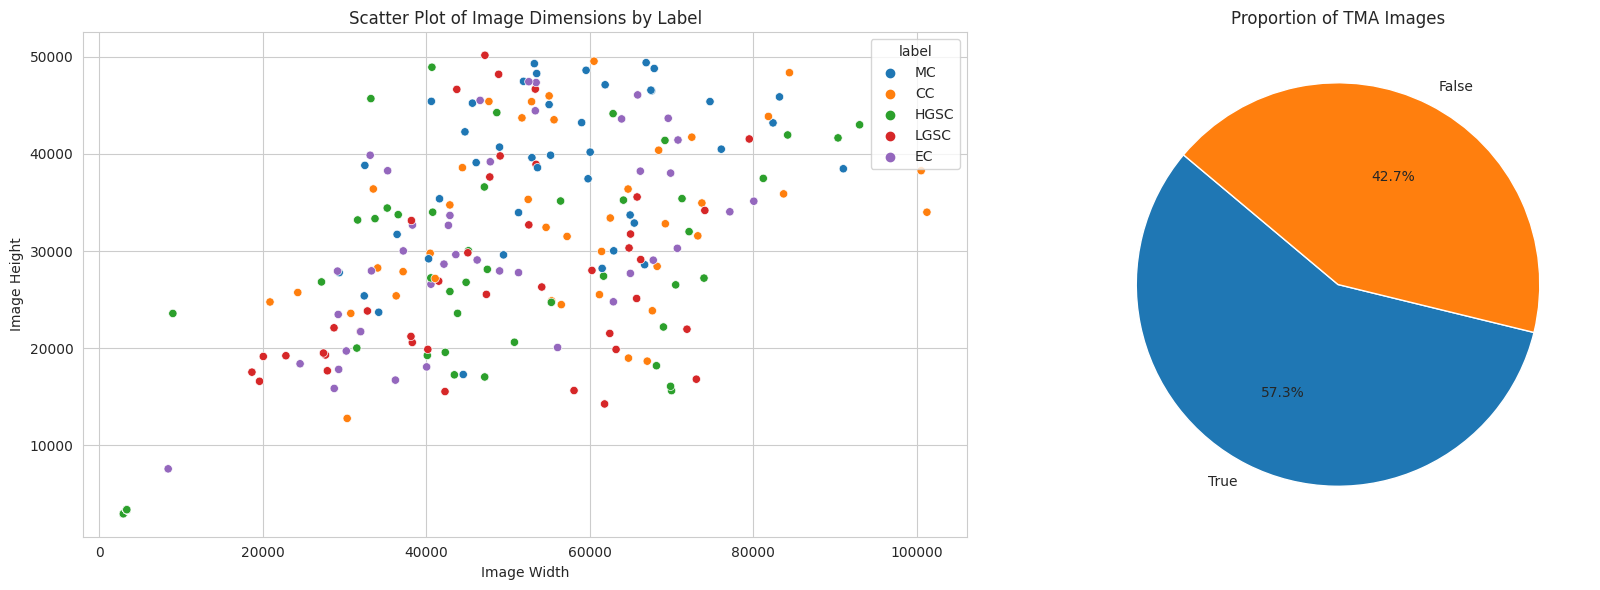

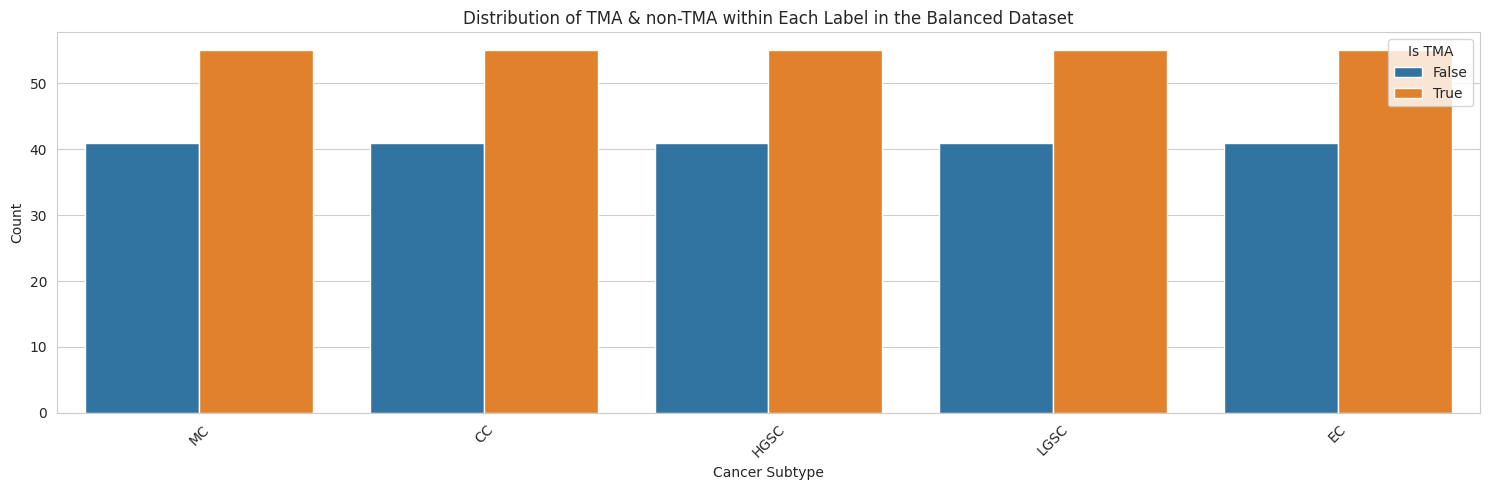

In [6]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

print()

# Prepare for multiple plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Scatter plot of image dimensions colored by label
sns.scatterplot(data=final_combined_data, x='image_width', y='image_height', hue='label', ax=axes[0])
axes[0].set_title('Scatter Plot of Image Dimensions by Label')
axes[0].set_xlabel('Image Width')
axes[0].set_ylabel('Image Height')

# Plot 2: Proportion of TMAs
tma_counts = final_combined_data['is_tma'].value_counts()
axes[1].pie(tma_counts, labels=tma_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Proportion of TMA Images')

plt.tight_layout()
plt.show()

print()
print()

# Now we can plot the distribution of TMA and non-TMA within each label for this balanced dataset
plt.figure(figsize=(15, 5))
sns.countplot(data=final_combined_data, x='label', hue='is_tma')
plt.title('Distribution of TMA & non-TMA within Each Label in the Balanced Dataset')
plt.xlabel('Cancer Subtype')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Is TMA', loc='upper right')
plt.tight_layout()
plt.show()

## Create a balanced DF with 10 WSI images from each of 5 classes

In [7]:
# Number of samples per label category
samples_per_label = 10

# Filter out the rows where is_tma is False
filtered_data = final_combined_data[final_combined_data['is_tma'] == False]

# Sample images in a balanced manner
balanced_samples = filtered_data.groupby('label').apply(lambda x: x.sample(samples_per_label)).reset_index(drop=True)

## Feature Extraction from WSI Tiles

In [9]:
# Increase the maximum number of pixels PIL can process
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Select the first 50 WSI images 
selected_images = balanced_samples

# Load a pre-trained model for feature extraction
model = timm.create_model('resnet50', pretrained=True, num_classes=0)
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_tile(tile):
    # Color Normalization (example with Reinhard method)
    #tile = color_normalize(tile, reference_image)

    # Contrast Enhancement using CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8)) # can play with clipLimit
    for i in range(tile.shape[2]):
        tile[:, :, i] = clahe.apply(tile[:, :, i])

    # Noise Reduction using Gaussian Blur
    tile = cv2.GaussianBlur(tile, (5, 5), 0)

    return tile
    
# Function to check if the tile has tissue present
def is_tissue_present(tile, area_threshold=0.2, low_saturation_threshold=20):
    hsv = cv2.cvtColor(tile, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    _, high_sat = cv2.threshold(s, low_saturation_threshold, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    tissue_mask = cv2.dilate(high_sat, kernel, iterations=2)
    tissue_mask = cv2.erode(tissue_mask, kernel, iterations=2)
    tissue_ratio = np.sum(tissue_mask > 0) / (tile_size * tile_size)
    return tissue_ratio > area_threshold

# Function to extract features from a tile
def extract_features(tile, model, transform):
    tile = Image.fromarray(tile)
    tile = transform(tile).unsqueeze(0)
    with torch.no_grad():
        features = model(tile)
    return features.squeeze(0).numpy()

# Define the size for the tiles
tile_size = 1024

slide_features = {}

# Process each image, extract tiles, extract features, and store them
total_images = len(selected_images)
for index, row in enumerate(selected_images.iterrows()):
    image_path = row[1]['path']
    label = row[1]['label']
    tile_features = []  # List to hold the features for the current image

     # Print the current status
    print(f"Processing image {index + 1} of {total_images}: {image_path}")
    
    # Open the image using Pillow
    with Image.open(image_path) as img:
        for y in range(0, img.height, tile_size):
            for x in range(0, img.width, tile_size):
                # Read the patch
                patch = img.crop((x, y, x + tile_size, y + tile_size))
                patch = np.array(patch)  # Convert PIL Image to NumPy array

                # Preprocess the patch
                preprocessed_patch = preprocess_tile(patch)

                # Check if the tile has tissue present and extract features
                if is_tissue_present(preprocessed_patch):
                    features = extract_features(preprocessed_patch, model, transform)
                    tile_features.append(features)

    # Store the extracted features and the label in the slide_features dictionary
    slide_features[image_path] = {
        'features': tile_features,
        'label': label
    }

# Now slide_features contains the feature vectors and labels for each of the 33 slides

Processing image 1 of 50: /kaggle/input/UBC-OCEAN/train_images/6449.png
Processing image 2 of 50: /kaggle/input/UBC-OCEAN/train_images/48506.png
Processing image 3 of 50: /kaggle/input/UBC-OCEAN/train_images/7482.png
Processing image 4 of 50: /kaggle/input/UBC-OCEAN/train_images/24563.png
Processing image 5 of 50: /kaggle/input/UBC-OCEAN/train_images/16325.png
Processing image 6 of 50: /kaggle/input/UBC-OCEAN/train_images/42296.png
Processing image 7 of 50: /kaggle/input/UBC-OCEAN/train_images/22155.png
Processing image 8 of 50: /kaggle/input/UBC-OCEAN/train_images/44283.png
Processing image 9 of 50: /kaggle/input/UBC-OCEAN/train_images/58974.png
Processing image 10 of 50: /kaggle/input/UBC-OCEAN/train_images/26219.png
Processing image 11 of 50: /kaggle/input/UBC-OCEAN/train_images/35754.png
Processing image 12 of 50: /kaggle/input/UBC-OCEAN/train_images/8531.png
Processing image 13 of 50: /kaggle/input/UBC-OCEAN/train_images/34822.png
Processing image 14 of 50: /kaggle/input/UBC-OCEAN

In [ ]:
with open('/kaggle/working/50slides_features.pkl', 'wb') as f:
    pickle.dump(slide_features, f)

In [9]:
with open('/kaggle/input/50slide-features/50slides_features.pkl', 'rb') as f:
    slide_features = pickle.load(f)

# Multiple Instance Learning (MIL) classifier model training 

### Feature data preparation

In [10]:
# Convert slide_features to a suitable format
data = [(features['features'], features['label']) for path, features in slide_features.items()]

# First split: Separate out a test set
train_val_data, test_data = train_test_split(data, test_size=0.2)

# Second split: Separate the remaining data into training and validation sets
train_data, val_data = train_test_split(train_val_data, test_size=0.25)  # 0.25 x 0.8 = 0.2 of the original data

#### Balanced split

In [11]:
# Organize data by labels
data_by_label = defaultdict(list)
for features, label in data:
    data_by_label[label].append((features, label))

# data_by_label is a dictionary where each key is a label and value is a list of corresponding data points

In [12]:
train_data = []
val_data = []
test_data = []

for label, label_data in data_by_label.items():
    # Split data for this label into train and test
    train_val_label_data, test_label_data = train_test_split(label_data, test_size=0.2)

    # Split train data into train and validation
    train_label_data, val_label_data = train_test_split(train_val_label_data, test_size=0.25)  # 0.25 x 0.8 = 0.2 of original

    # Append split data to respective sets
    train_data.extend(train_label_data)
    val_data.extend(val_label_data)
    test_data.extend(test_label_data)

In [13]:
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

In [14]:
def check_balance(dataset):
    label_counts = defaultdict(int)
    for _, label in dataset:
        label_counts[label] += 1
    return dict(label_counts)

print("Train balance:", check_balance(train_data))
print("Validation balance:", check_balance(val_data))
print("Test balance:", check_balance(test_data))

Train balance: {'HGSC': 6, 'MC': 6, 'CC': 6, 'EC': 6, 'LGSC': 6}
Validation balance: {'LGSC': 2, 'EC': 2, 'HGSC': 2, 'CC': 2, 'MC': 2}
Test balance: {'LGSC': 2, 'MC': 2, 'HGSC': 2, 'EC': 2, 'CC': 2}


### Clustering feature vectors of all images

In [16]:
all_features = []
all_labels = []

for key, value in slide_features.items():
    for feature_vector in value['features']:
        all_features.append(feature_vector)
        all_labels.append(value['label'])

all_features = np.array(all_features)
all_labels = np.array(all_labels)

In [17]:
umap_reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean')
umap_embedding = umap_reducer.fit_transform(all_features)

In [19]:
# Adjust HDBSCAN parameters
min_cluster_size = 10  # Increase for larger minimum cluster size
min_samples = 20  # Increase to reduce noise
epsilon = 0.19  # Adjust based on distance threshold
alpha = 1.0  # Adjust density threshold for cluster formatio

# Perform clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=epsilon, alpha=alpha, gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(umap_embedding)

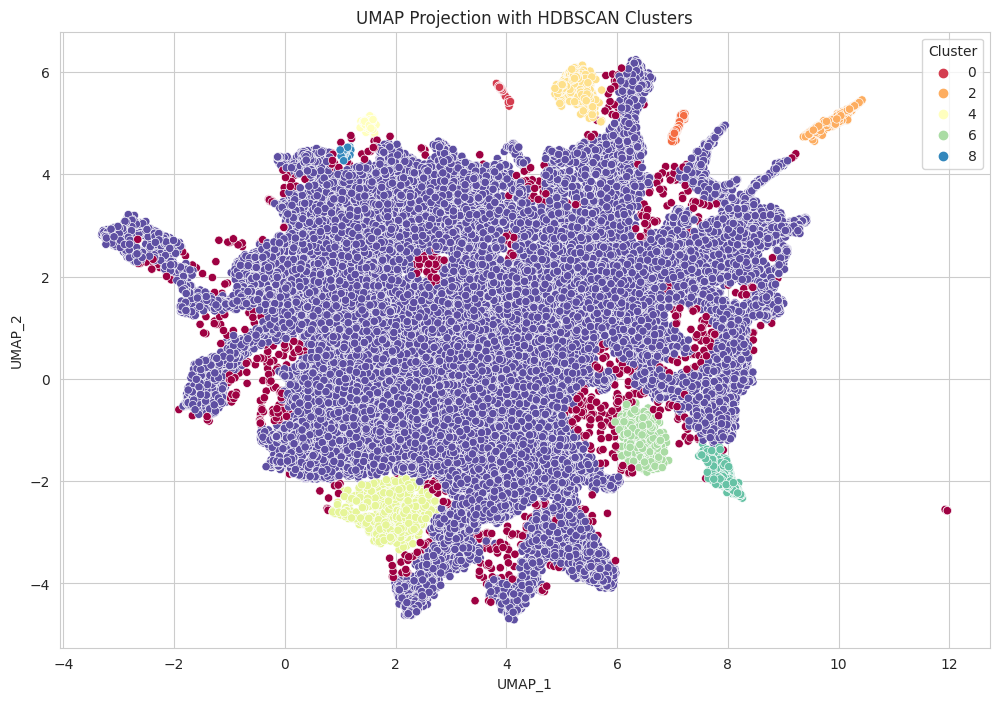

In [20]:
# Convert the UMAP embedding and cluster labels to a pandas DataFrame for plotting
embedding_df = pd.DataFrame(umap_embedding, columns=['UMAP_1', 'UMAP_2'])
embedding_df['Cluster'] = cluster_labels

# Plot using Seaborn's scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=embedding_df, x='UMAP_1', y='UMAP_2', hue='Cluster', palette='Spectral')
plt.title("UMAP Projection with HDBSCAN Clusters")
plt.show()

Cluster 0 label distribution:
Original_Label
MC      45
HGSC     2
Name: count, dtype: int64



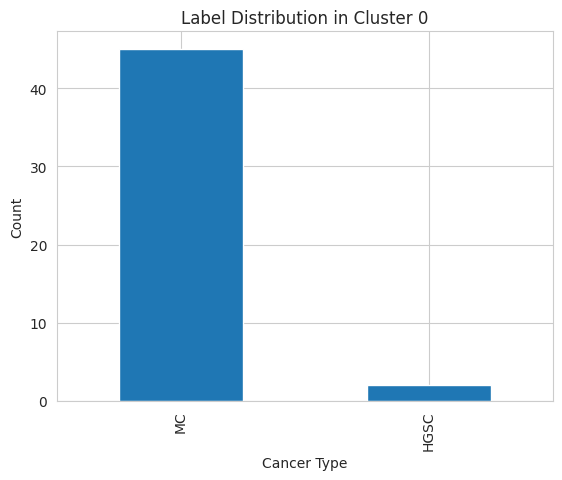

Cluster 1 label distribution:
Original_Label
LGSC    98
Name: count, dtype: int64



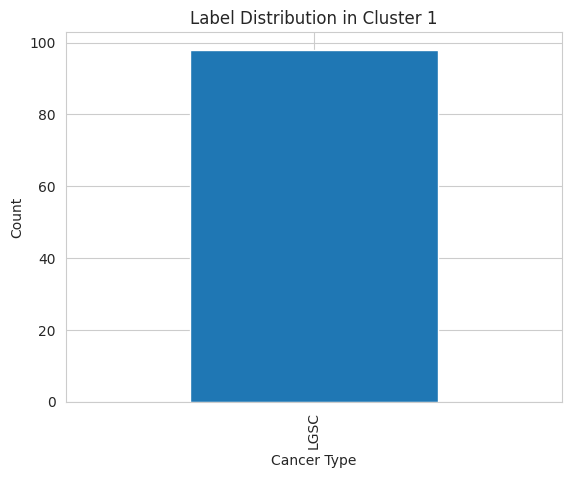

Cluster 2 label distribution:
Original_Label
HGSC    368
EC       24
CC        3
Name: count, dtype: int64



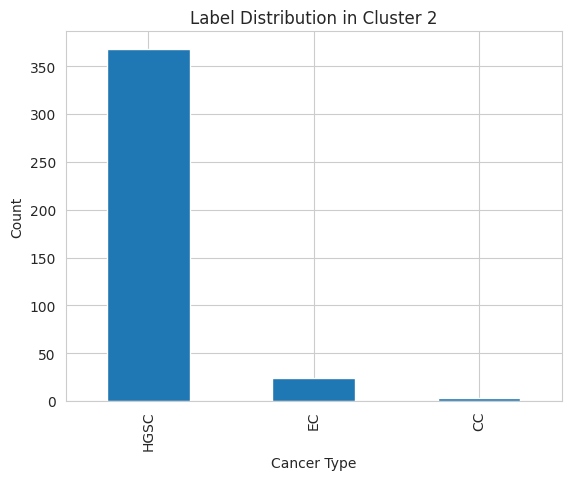

Cluster 3 label distribution:
Original_Label
CC      600
LGSC      6
EC        2
HGSC      2
MC        1
Name: count, dtype: int64



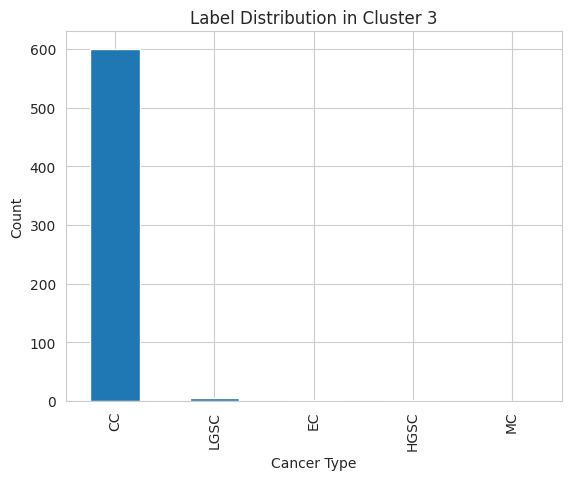

Cluster 4 label distribution:
Original_Label
MC    108
Name: count, dtype: int64



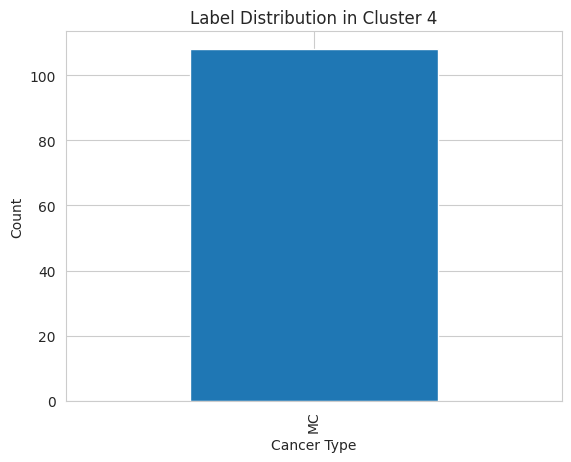

Cluster 5 label distribution:
Original_Label
EC      879
MC       35
HGSC     33
CC        9
LGSC      6
Name: count, dtype: int64



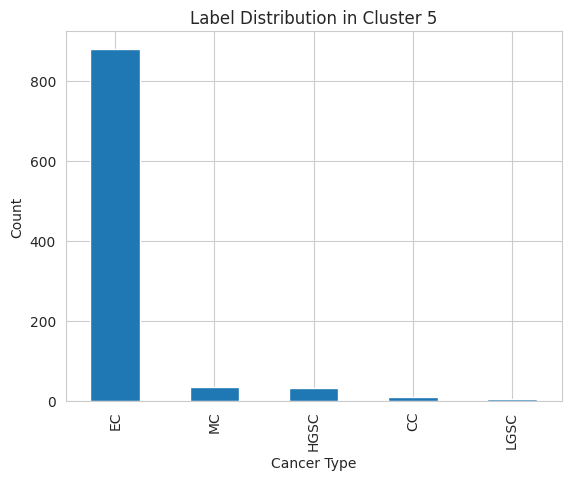

Cluster 6 label distribution:
Original_Label
CC      719
MC        7
EC        3
HGSC      2
LGSC      1
Name: count, dtype: int64



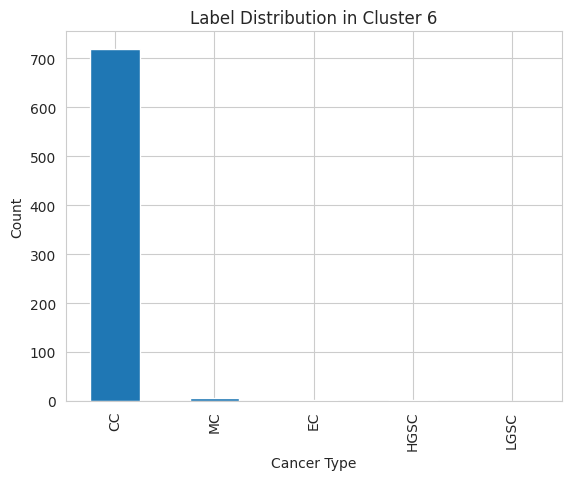

Cluster 7 label distribution:
Original_Label
EC      381
MC        3
LGSC      2
Name: count, dtype: int64



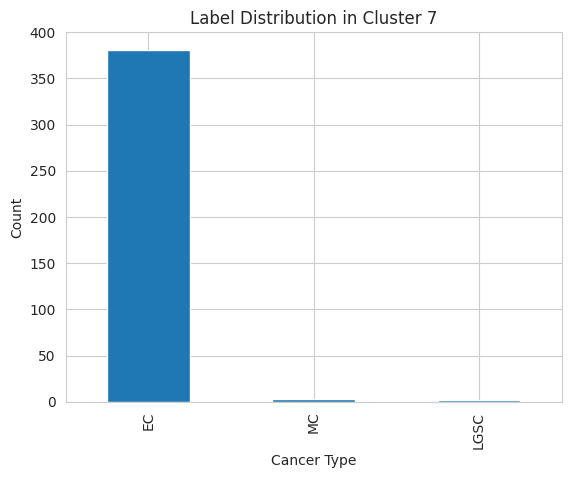

Cluster 8 label distribution:
Original_Label
MC    36
Name: count, dtype: int64



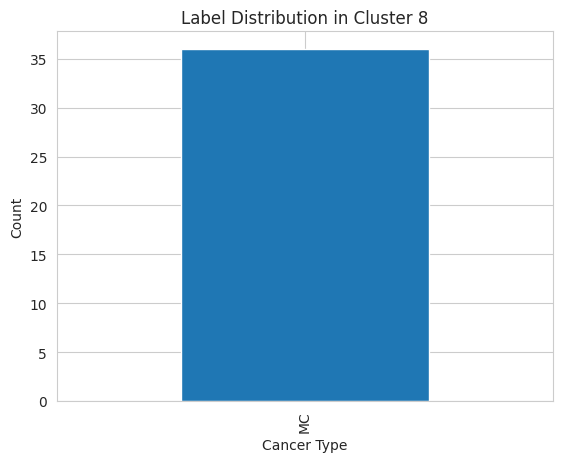

In [21]:
# Create a DataFrame with UMAP embeddings, HDBSCAN cluster labels, and original labels
embedding_df['Original_Label'] = all_labels

# Analyze the labels for each cluster
for cluster in range(0, 9):  # Assuming clusters are numbered 0 to 4
    cluster_data = embedding_df[embedding_df['Cluster'] == cluster]
    label_counts = cluster_data['Original_Label'].value_counts()
    print(f"Cluster {cluster} label distribution:\n{label_counts}\n")

    # Optionally, create a bar plot for each cluster's label distribution
    label_counts.plot(kind='bar')
    plt.title(f"Label Distribution in Cluster {cluster}")
    plt.xlabel("Cancer Type")
    plt.ylabel("Count")
    plt.show()

### Cluster feature vectors for training set

In [22]:
train_features = []
train_labels = []

# Iterate over the training data to aggregate features and labels
for bag, label in train_data:
    for feature_vector in bag:
        train_features.append(feature_vector)
        train_labels.append(label)

# Convert to NumPy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

In [24]:
# UMAP on training data features
umap_embedding_train = umap_reducer.fit_transform(train_features)

# Adjust HDBSCAN parameters
min_cluster_size = 5  # Increase for larger minimum cluster size
min_samples = 20  # Increase to reduce noise
epsilon = 0.19  # Adjust based on distance threshold
alpha = 1.0  # Adjust density threshold for cluster formation

# Clustering with HDBSCAN
cluster_labels_train = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=epsilon,
                                       alpha=alpha, gen_min_span_tree=True).fit_predict(umap_embedding_train)

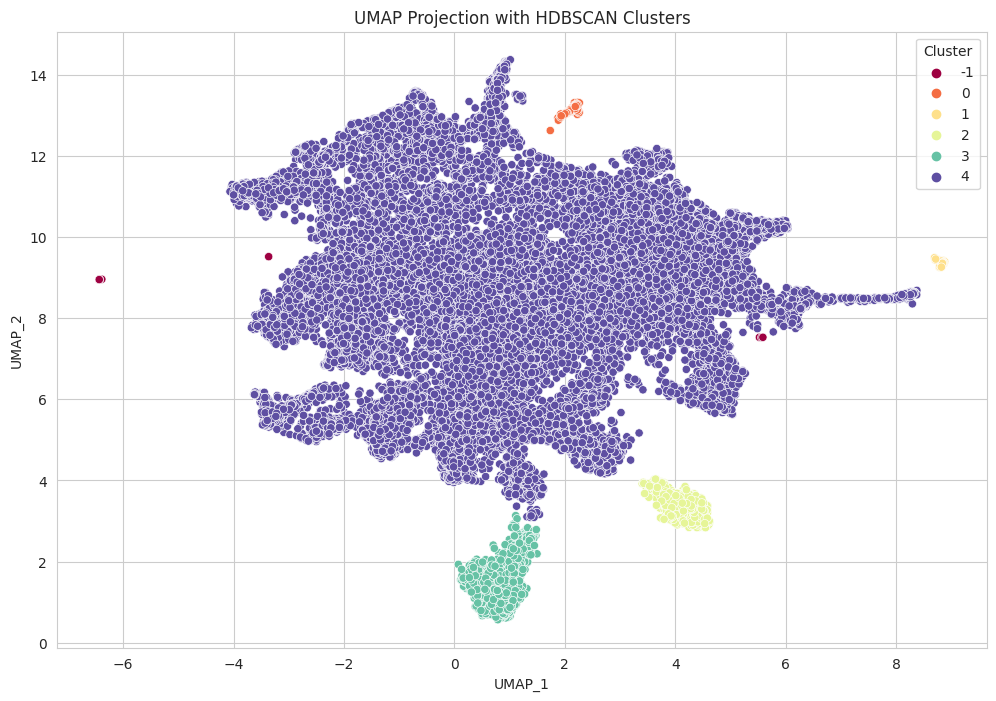

In [25]:
# Convert the UMAP embedding and cluster labels to a pandas DataFrame for plotting
embedding_df_train = pd.DataFrame(umap_embedding_train, columns=['UMAP_1', 'UMAP_2'])
embedding_df_train['Cluster'] = cluster_labels_train

# Plot using Seaborn's scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=embedding_df_train, x='UMAP_1', y='UMAP_2', hue='Cluster', palette='Spectral')
plt.title("UMAP Projection with HDBSCAN Clusters")
plt.show()

Cluster 0 label distribution:
Original_Label
MC      45
HGSC     2
Name: count, dtype: int64



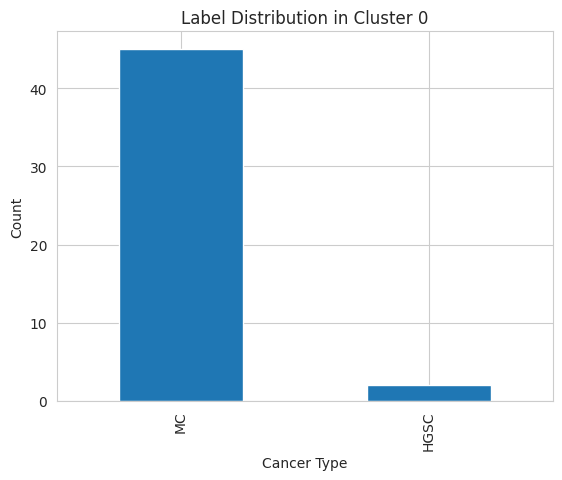

Cluster 1 label distribution:
Original_Label
LGSC    98
Name: count, dtype: int64



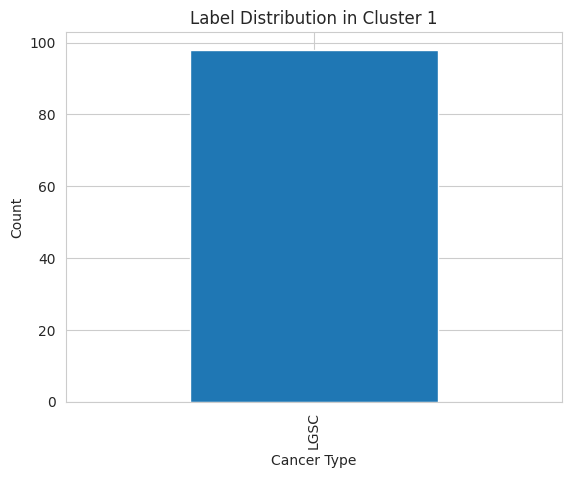

Cluster 2 label distribution:
Original_Label
HGSC    368
EC       24
CC        3
Name: count, dtype: int64



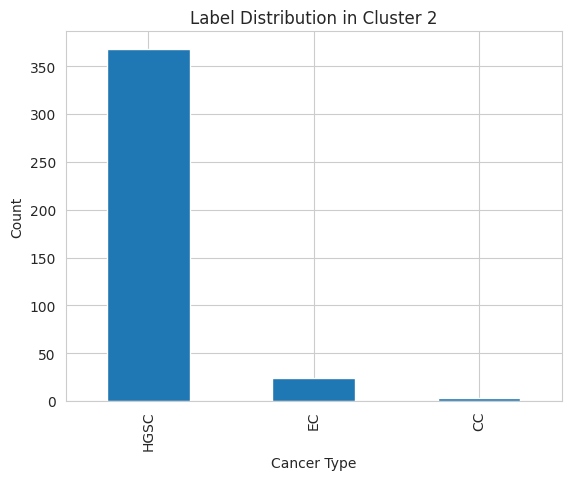

Cluster 3 label distribution:
Original_Label
CC      600
LGSC      6
EC        2
HGSC      2
MC        1
Name: count, dtype: int64



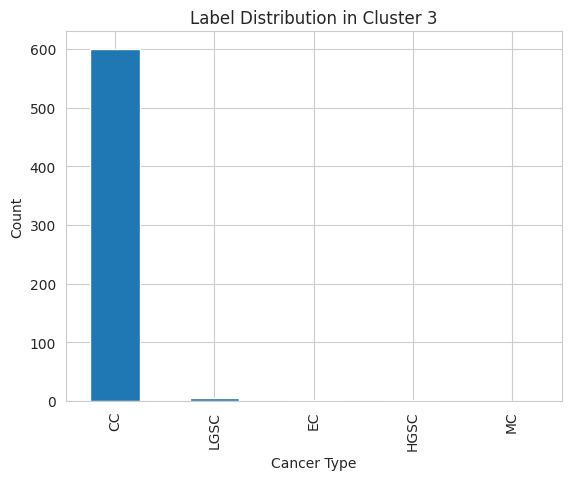

Cluster 4 label distribution:
Original_Label
MC    108
Name: count, dtype: int64



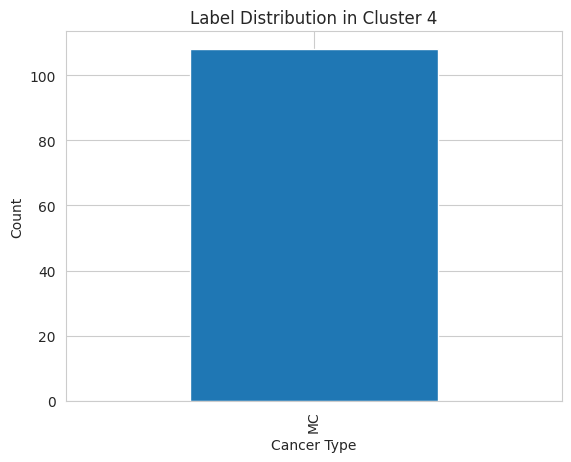

Cluster 5 label distribution:
Original_Label
EC      879
MC       35
HGSC     33
CC        9
LGSC      6
Name: count, dtype: int64



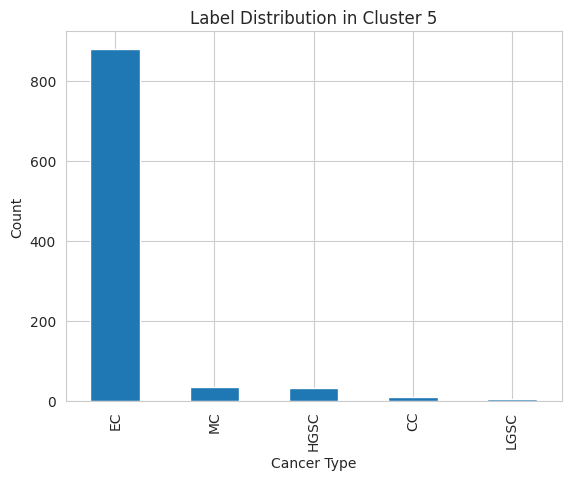

Cluster 6 label distribution:
Original_Label
CC      719
MC        7
EC        3
HGSC      2
LGSC      1
Name: count, dtype: int64



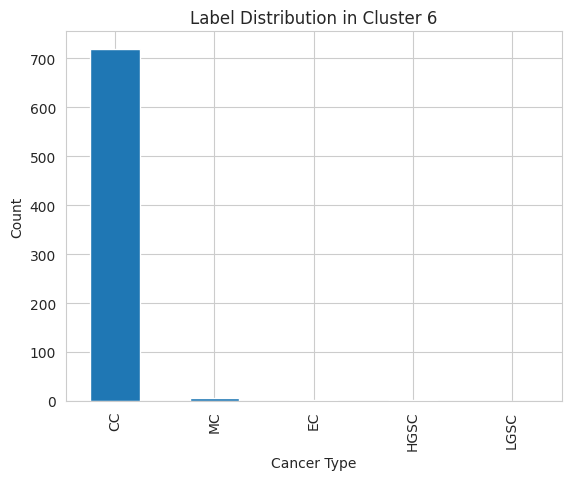

Cluster 7 label distribution:
Original_Label
EC      381
MC        3
LGSC      2
Name: count, dtype: int64



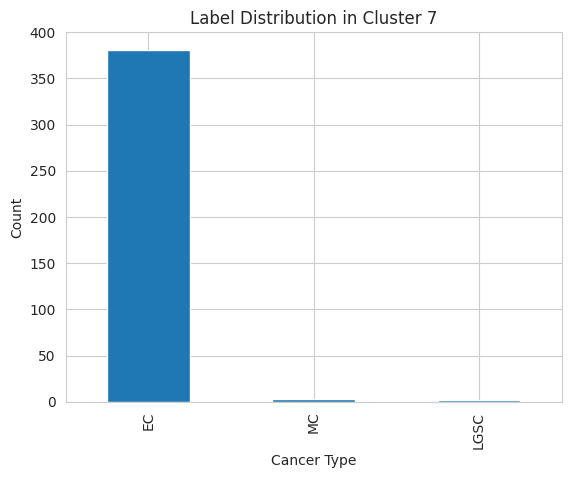

Cluster 8 label distribution:
Original_Label
MC    36
Name: count, dtype: int64



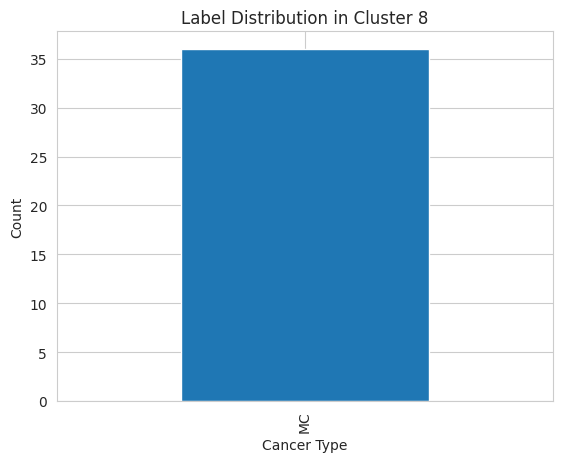

In [27]:
# Create a DataFrame with UMAP embeddings, HDBSCAN cluster labels, and original labels
embedding_df['Original_Label'] = all_labels

# Analyze the labels for each cluster
for cluster in range(0, 9):  # Assuming clusters are numbered 0 to 4
    cluster_data = embedding_df[embedding_df['Cluster'] == cluster]
    label_counts = cluster_data['Original_Label'].value_counts()
    print(f"Cluster {cluster} label distribution:\n{label_counts}\n")

    # Optionally, create a bar plot for each cluster's label distribution
    label_counts.plot(kind='bar')
    plt.title(f"Label Distribution in Cluster {cluster}")
    plt.xlabel("Cancer Type")
    plt.ylabel("Count")
    plt.show()

## Select Representative Feature Vectors:
Select a fixed number of representative vectors from each cluster based on your clustering results.

In [28]:
num_representatives = 10  # Number of representatives to select from each cluster
representative_features = defaultdict(list)

for cluster in np.unique(cluster_labels_train):
    if cluster == 9:
        continue  # Skip cluster
    cluster_indices = np.where(cluster_labels_train == cluster)[0]
    selected_indices = np.random.choice(cluster_indices, num_representatives, replace=False)
    for idx in selected_indices:
        representative_features[cluster].append(train_features[idx])

## Augment Training Bags with Representatives:
Now, use these representative feature vectors to augment the training bags in train_data.

In [29]:
augmented_train_data = []

for bag_features, label in train_data:
    augmented_bag = bag_features.copy()

    # Add representatives from each cluster to the bag
    for cluster_reps in representative_features.values():
        augmented_bag.extend(cluster_reps)
    
    augmented_train_data.append((augmented_bag, label))

## Create Datasets and DataLoaders with Augmented Training Data:
With the augmented training data, create your MILDataset and DataLoader:

In [30]:
# Create a mapping from label strings to integers
unique_labels = sorted(set(label for _, label in data))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

class MILDataset(Dataset):
    def __init__(self, data, label_to_idx):
        self.data = data
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature_vectors, label = self.data[idx]
        label_idx = self.label_to_idx[label]  # Convert label to integer
        return torch.tensor(feature_vectors), torch.tensor(label_idx, dtype=torch.float32)

# Creating the datasets with augmented training data
train_dataset = MILDataset(augmented_train_data, label_to_idx)
val_dataset = MILDataset(val_data, label_to_idx)
test_dataset = MILDataset(test_data, label_to_idx)

# DataLoaders remain the same
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Train and Test the MIL Model:
Proceed to train and test your MIL model using this augmented training data.

In [43]:
class AttentionMIL(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(AttentionMIL, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim) # Batch normalization
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=0)
        )
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, bag):
        h = self.bn1(torch.relu(self.fc1(bag)))  # Batch normalization
        h = torch.relu(self.fc1(bag))
        a = self.attention(h)
        v = torch.sum(a * h, dim=0)
        y = self.classifier(v)
        return y, a

# Number of unique classes
num_classes = len(unique_labels)

model = AttentionMIL(input_dim=2048, hidden_dim=256, num_classes=num_classes)
loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss for multiclass
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Early Stopping Parameters
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Model Training with Validation
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Training loop
    for bags, labels in train_loader:
        optimizer.zero_grad()
        bags = bags.squeeze(0)  # Remove the extra dimension from bags
        labels = labels.squeeze(0).long()  # Remove extra dimension and ensure long type for labels
        output, _ = model(bags)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 0)
        train_total += 1
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for bags, labels in val_loader:
            bags = bags.squeeze(0)
            labels = labels.squeeze(0).long()
            output, _ = model(bags)
            loss = loss_function(output, labels)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 0)
            val_total += 1
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    
    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/50, Train Loss: 1.6892, Train Acc: 16.67%, Validation Loss: 1.5982, Val Acc: 30.00%
Epoch 2/50, Train Loss: 1.5758, Train Acc: 43.33%, Validation Loss: 1.5872, Val Acc: 30.00%
Epoch 3/50, Train Loss: 1.5860, Train Acc: 26.67%, Validation Loss: 1.5701, Val Acc: 20.00%
Epoch 4/50, Train Loss: 1.5196, Train Acc: 30.00%, Validation Loss: 1.5467, Val Acc: 20.00%
Epoch 5/50, Train Loss: 1.4529, Train Acc: 40.00%, Validation Loss: 1.5340, Val Acc: 20.00%
Epoch 6/50, Train Loss: 1.4292, Train Acc: 30.00%, Validation Loss: 1.5133, Val Acc: 40.00%
Epoch 7/50, Train Loss: 1.3092, Train Acc: 53.33%, Validation Loss: 1.5271, Val Acc: 20.00%
Epoch 8/50, Train Loss: 1.2810, Train Acc: 36.67%, Validation Loss: 1.5546, Val Acc: 20.00%
Epoch 9/50, Train Loss: 1.1245, Train Acc: 66.67%, Validation Loss: 1.5298, Val Acc: 20.00%
Epoch 10/50, Train Loss: 0.9620, Train Acc: 66.67%, Validation Loss: 1.6252, Val Acc: 30.00%
Stopping early due to no improvement in validation loss.


In [44]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for bags, labels in test_loader:
        output, _ = model(bags.squeeze(0))
        _, predicted_labels = torch.max(output, 0)  # Get the index of the max log-probability
        predictions.append(predicted_labels.item())  # Append scalar value
        true_labels.append(labels.squeeze(0).item())  # Append scalar value

# Convert lists to arrays for metric calculation
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro', zero_division=1)
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.5000
Precision: 0.6833
Recall: 0.5000
F1 Score: 0.4600


In [45]:
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Use idx_to_label to map numeric predictions back to label names
predicted_labels = [idx_to_label[int(idx)] for idx in predictions]
true_label_names = [idx_to_label[int(idx)] for idx in true_labels]

# Now predicted_labels and true_label_names contain the label names
print(predicted_labels)
print(true_label_names)

['LGSC', 'HGSC', 'LGSC', 'HGSC', 'EC', 'LGSC', 'CC', 'HGSC', 'HGSC', 'CC']
['LGSC', 'MC', 'HGSC', 'EC', 'EC', 'LGSC', 'MC', 'HGSC', 'CC', 'CC']
